In [1]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Reshape, Input,merge
from keras.layers.merge import concatenate
from keras.layers.core import Activation, Dropout, Flatten,Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D,Conv2D, MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
from facade_dataset import FacadeDataset
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


In [2]:
train_d = FacadeDataset().dataset

load dataset start
     from: ./dataset/base/
load dataset done


In [3]:
def CBR(ch,shape,bn=True,sample='down',activation=LeakyReLU, dropout=False):
    model = Sequential()
    if sample=='down':
        model.add(Conv2D(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    else:
        model.add(Conv2DTranspose(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    if activation == LeakyReLU:
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation('relu'))
    
    return model

In [22]:
def PatchGan(patch_size):
    p = patch_size
    input1 = Input(shape=(p,p,1))
    input2 = Input(shape=(p,p,3))
    x1 = CBR(32,(p,p,1))(input1)
    x2 = CBR(32,(p,p,3))(input2)
    x = concatenate([x1,x2])
    x = CBR(128,(int(p/2),int(p/2),64))(x)
    x = CBR(256,(int(int(p/2)/2),int(int(p/2)/2),128))(x)
    output = Dense(2,activation='softmax')(x)
    model = Model(inputs=[input1,input2], outputs=output)
    return model

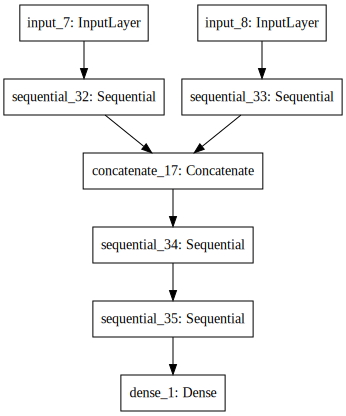

In [23]:
model = PatchGan(4)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [24]:
def discriminator(patch_size=4):
    h = 256
    w = 256
    ph = patch_size
    pw = patch_size
    gen_input = Input(shape=(h,w,3))
    img_input = Input(shape=(h,w,1))
    list_row_idx = [(i * ph, (i + 1) * ph) for i in range(int(h / ph))]
    list_col_idx = [(i * pw, (i + 1) * pw) for i in range(int(w / pw))]
    pg = PatchGan(patch_size)
    pg_list = []
    
    for row_idx in list_row_idx:
        print(row_idx)
        for col_idx in list_col_idx:
            gen_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(gen_input)
            img_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(img_input)
            x = pg([img_patch,gen_patch])
            pg_list.append(x)
    output = concatenate(pg_list)
    model = Model(inputs =[img_input,gen_input], outputs = output)
    return model

(0, 64)
(64, 128)
(128, 192)
(192, 256)


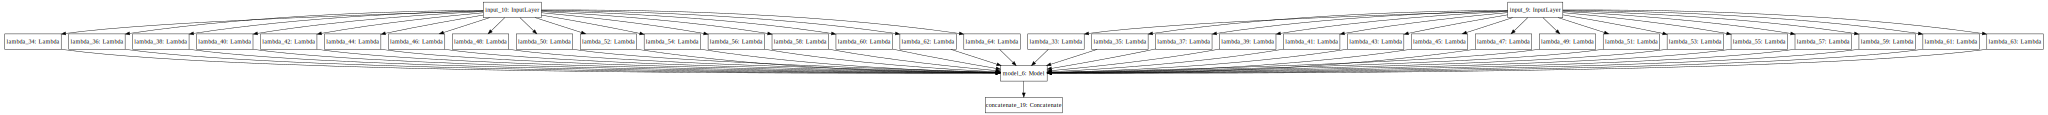

In [25]:
dis = discriminator(patch_size=64)
SVG(model_to_dot(dis).create(prog='dot', format='svg'))

In [5]:
def generator():
    
    # encoder
    input1 = Input(shape=(256,256,1))
    enc_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=(256,256,1))(input1)
    enc_2 = CBR(128,(256,256,64))(enc_1)
    enc_3 = CBR(256,(128,128,128))(enc_2)
    enc_4 = CBR(512,(64,64,256))(enc_3)
    enc_5 = CBR(512,(32,32,512))(enc_4)
    enc_6 = CBR(512,(16,16,512))(enc_5)
    enc_7 = CBR(512,(8,8,512))(enc_6)
    enc_8 = CBR(512,(4,4,512))(enc_7)
    
    # decoder
    x = CBR(512,(2,2,512),sample='up',activation='relu',dropout=True)(enc_8)
    x = CBR(512,(4,4,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_7]))
    x = CBR(512,(8,8,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_6]))
    x = CBR(512,(16,16,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_5]))
    x = CBR(256,(32,32,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_4]))
    
    x = CBR(128,(64,64,512),sample='up',activation='relu',dropout=True)(concatenate([x,enc_3]))
    x = CBR(64,(128,128,256),sample='up',activation='relu',dropout=True)(concatenate([x,enc_2]))
    output = Conv2D(filters=3, kernel_size=(3,3),strides=1,padding="same")(concatenate([x,enc_1]))
     
    model = Model(inputs=input1, outputs=output)
    return(model)

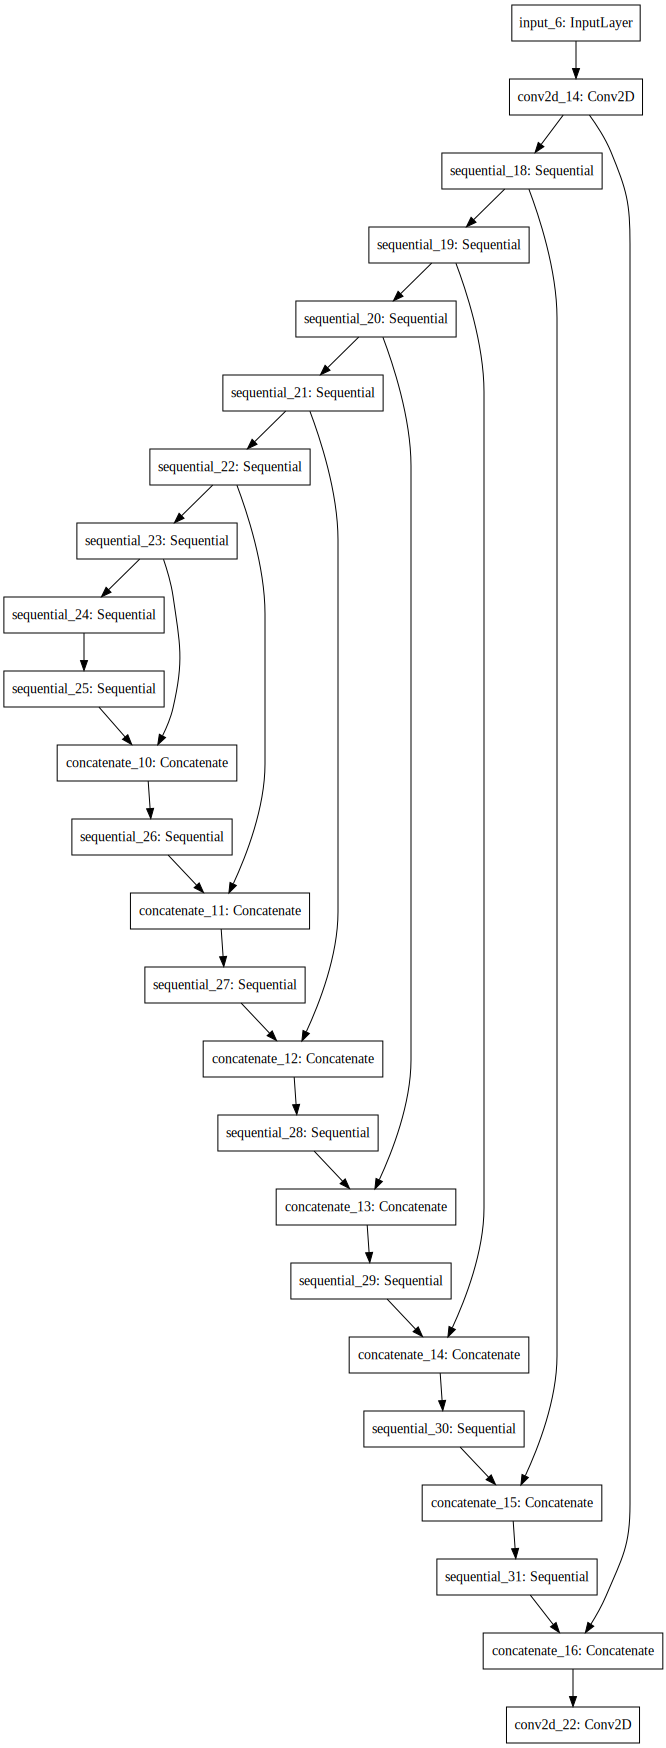

In [13]:
gen = generator()
SVG(model_to_dot(gen).create(prog='dot', format='svg'))

In [73]:
def GAN(generator, discriminator,  patch_size=4):

    gen_input = Input(shape=(256,256,1))
    label_Input = Input(shape=(256,256,3))
    
    generated_image = generator(gen_input)


    h, w = 256,256
    ph = patch_size
    pw = patch_size

    list_row_idx = [(i * ph, (i + 1) * ph) for i in range(int(h / ph))]
    list_col_idx = [(i * pw, (i + 1) * pw) for i in range(int(w / pw))]

    list_gen_patch = []
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(generated_image)
            list_gen_patch.append(x_patch)

    DCGAN_output = discriminator(list_gen_patch)

    DCGAN = Model(input=[gen_input,label_input],
                  output=[generated_image, DCGAN_output],
                  name="DCGAN")

    return DCGAN

In [74]:
gan = GAN(gen,dis)
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

ValueError: Layer model_1 expects 2 inputs, but it received 4096 input tensors. Input received: [<tf.Tensor 'lambda_1/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_5/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_6/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_7/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_8/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_9/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_10/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_11/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_12/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_13/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_14/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_15/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_16/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_17/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_18/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_19/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_20/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_21/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_22/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_23/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_24/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_25/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_26/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_27/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_28/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_29/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_30/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_31/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_32/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_33/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_34/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_35/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_36/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_37/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_38/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_39/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_40/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_41/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_42/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_43/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_44/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_45/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_46/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_47/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_48/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_49/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_50/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_51/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_52/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_53/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_54/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_55/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_56/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_57/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_58/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_59/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_60/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_61/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_62/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_63/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_64/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_65/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_66/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_67/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_68/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_69/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_70/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_71/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_72/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_73/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_74/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_75/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_76/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_77/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_78/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_79/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_80/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_81/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_82/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_83/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_84/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_85/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_86/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_87/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_88/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_89/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_90/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_91/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_92/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_93/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_94/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_95/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_96/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_97/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_98/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_99/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_100/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_101/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_102/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_103/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_104/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_105/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_106/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_107/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_108/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_109/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_110/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_111/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_112/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_113/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_114/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_115/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_116/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_117/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_118/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_119/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_120/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_121/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_122/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_123/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_124/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_125/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_126/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_127/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_128/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_129/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_130/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_131/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_132/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_133/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_134/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_135/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_136/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_137/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_138/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_139/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_140/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_141/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_142/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_143/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_144/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_145/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_146/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_147/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_148/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_149/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_150/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_151/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_152/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_153/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_154/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_155/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_156/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_157/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_158/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_159/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_160/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_161/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_162/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_163/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_164/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_165/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_166/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_167/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_168/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_169/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_170/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_171/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_172/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_173/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_174/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_175/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_176/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_177/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_178/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_179/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_180/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_181/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_182/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_183/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_184/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_185/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_186/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_187/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_188/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_189/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_190/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_191/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_192/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_193/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_194/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_195/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_196/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_197/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_198/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_199/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_200/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_201/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_202/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_203/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_204/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_205/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_206/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_207/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_208/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_209/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_210/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_211/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_212/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_213/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_214/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_215/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_216/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_217/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_218/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_219/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_220/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_221/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_222/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_223/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_224/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_225/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_226/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_227/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_228/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_229/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_230/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_231/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_232/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_233/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_234/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_235/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_236/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_237/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_238/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_239/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_240/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_241/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_242/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_243/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_244/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_245/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_246/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_247/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_248/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_249/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_250/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_251/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_252/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_253/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_254/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_255/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_256/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_257/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_258/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_259/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_260/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_261/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_262/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_263/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_264/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_265/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_266/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_267/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_268/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_269/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_270/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_271/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_272/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_273/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_274/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_275/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_276/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_277/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_278/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_279/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_280/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_281/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_282/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_283/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_284/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_285/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_286/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_287/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_288/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_289/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_290/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_291/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_292/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_293/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_294/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_295/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_296/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_297/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_298/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_299/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_300/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_301/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_302/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_303/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_304/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_305/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_306/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_307/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_308/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_309/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_310/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_311/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_312/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_313/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_314/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_315/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_316/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_317/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_318/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_319/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_320/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_321/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_322/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_323/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_324/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_325/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_326/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_327/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_328/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_329/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_330/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_331/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_332/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_333/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_334/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_335/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_336/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_337/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_338/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_339/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_340/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_341/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_342/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_343/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_344/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_345/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_346/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_347/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_348/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_349/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_350/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_351/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_352/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_353/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_354/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_355/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_356/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_357/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_358/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_359/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_360/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_361/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_362/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_363/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_364/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_365/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_366/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_367/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_368/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_369/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_370/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_371/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_372/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_373/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_374/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_375/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_376/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_377/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_378/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_379/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_380/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_381/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_382/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_383/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_384/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_385/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_386/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_387/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_388/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_389/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_390/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_391/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_392/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_393/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_394/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_395/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_396/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_397/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_398/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_399/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_400/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_401/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_402/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_403/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_404/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_405/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_406/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_407/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_408/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_409/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_410/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_411/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_412/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_413/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_414/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_415/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_416/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_417/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_418/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_419/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_420/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_421/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_422/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_423/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_424/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_425/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_426/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_427/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_428/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_429/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_430/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_431/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_432/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_433/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_434/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_435/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_436/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_437/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_438/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_439/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_440/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_441/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_442/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_443/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_444/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_445/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_446/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_447/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_448/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_449/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_450/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_451/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_452/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_453/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_454/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_455/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_456/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_457/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_458/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_459/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_460/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_461/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_462/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_463/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_464/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_465/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_466/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_467/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_468/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_469/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_470/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_471/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_472/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_473/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_474/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_475/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_476/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_477/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_478/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_479/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_480/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_481/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_482/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_483/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_484/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_485/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_486/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_487/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_488/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_489/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_490/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_491/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_492/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_493/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_494/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_495/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_496/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_497/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_498/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_499/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_500/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_501/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_502/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_503/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_504/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_505/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_506/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_507/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_508/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_509/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_510/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_511/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_512/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_513/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_514/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_515/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_516/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_517/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_518/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_519/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_520/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_521/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_522/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_523/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_524/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_525/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_526/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_527/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_528/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_529/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_530/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_531/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_532/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_533/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_534/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_535/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_536/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_537/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_538/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_539/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_540/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_541/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_542/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_543/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_544/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_545/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_546/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_547/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_548/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_549/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_550/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_551/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_552/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_553/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_554/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_555/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_556/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_557/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_558/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_559/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_560/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_561/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_562/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_563/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_564/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_565/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_566/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_567/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_568/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_569/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_570/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_571/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_572/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_573/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_574/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_575/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_576/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_577/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_578/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_579/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_580/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_581/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_582/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_583/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_584/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_585/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_586/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_587/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_588/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_589/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_590/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_591/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_592/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_593/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_594/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_595/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_596/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_597/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_598/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_599/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_600/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_601/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_602/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_603/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_604/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_605/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_606/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_607/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_608/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_609/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_610/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_611/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_612/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_613/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_614/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_615/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_616/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_617/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_618/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_619/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_620/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_621/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_622/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_623/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_624/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_625/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_626/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_627/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_628/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_629/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_630/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_631/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_632/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_633/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_634/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_635/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_636/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_637/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_638/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_639/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_640/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_641/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_642/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_643/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_644/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_645/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_646/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_647/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_648/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_649/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_650/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_651/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_652/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_653/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_654/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_655/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_656/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_657/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_658/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_659/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_660/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_661/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_662/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_663/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_664/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_665/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_666/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_667/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_668/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_669/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_670/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_671/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_672/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_673/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_674/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_675/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_676/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_677/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_678/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_679/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_680/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_681/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_682/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_683/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_684/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_685/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_686/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_687/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_688/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_689/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_690/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_691/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_692/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_693/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_694/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_695/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_696/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_697/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_698/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_699/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_700/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_701/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_702/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_703/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_704/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_705/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_706/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_707/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_708/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_709/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_710/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_711/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_712/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_713/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_714/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_715/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_716/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_717/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_718/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_719/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_720/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_721/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_722/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_723/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_724/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_725/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_726/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_727/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_728/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_729/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_730/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_731/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_732/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_733/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_734/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_735/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_736/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_737/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_738/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_739/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_740/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_741/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_742/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_743/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_744/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_745/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_746/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_747/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_748/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_749/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_750/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_751/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_752/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_753/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_754/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_755/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_756/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_757/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_758/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_759/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_760/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_761/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_762/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_763/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_764/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_765/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_766/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_767/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_768/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_769/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_770/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_771/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_772/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_773/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_774/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_775/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_776/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_777/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_778/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_779/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_780/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_781/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_782/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_783/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_784/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_785/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_786/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_787/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_788/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_789/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_790/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_791/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_792/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_793/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_794/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_795/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_796/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_797/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_798/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_799/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_800/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_801/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_802/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_803/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_804/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_805/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_806/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_807/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_808/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_809/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_810/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_811/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_812/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_813/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_814/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_815/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_816/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_817/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_818/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_819/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_820/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_821/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_822/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_823/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_824/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_825/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_826/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_827/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_828/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_829/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_830/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_831/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_832/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_833/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_834/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_835/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_836/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_837/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_838/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_839/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_840/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_841/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_842/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_843/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_844/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_845/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_846/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_847/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_848/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_849/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_850/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_851/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_852/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_853/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_854/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_855/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_856/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_857/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_858/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_859/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_860/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_861/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_862/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_863/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_864/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_865/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_866/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_867/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_868/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_869/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_870/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_871/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_872/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_873/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_874/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_875/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_876/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_877/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_878/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_879/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_880/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_881/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_882/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_883/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_884/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_885/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_886/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_887/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_888/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_889/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_890/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_891/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_892/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_893/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_894/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_895/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_896/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_897/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_898/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_899/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_900/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_901/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_902/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_903/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_904/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_905/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_906/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_907/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_908/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_909/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_910/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_911/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_912/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_913/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_914/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_915/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_916/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_917/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_918/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_919/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_920/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_921/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_922/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_923/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_924/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_925/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_926/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_927/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_928/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_929/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_930/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_931/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_932/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_933/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_934/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_935/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_936/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_937/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_938/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_939/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_940/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_941/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_942/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_943/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_944/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_945/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_946/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_947/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_948/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_949/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_950/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_951/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_952/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_953/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_954/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_955/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_956/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_957/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_958/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_959/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_960/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_961/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_962/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_963/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_964/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_965/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_966/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_967/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_968/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_969/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_970/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_971/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_972/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_973/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_974/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_975/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_976/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_977/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_978/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_979/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_980/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_981/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_982/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_983/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_984/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_985/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_986/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_987/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_988/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_989/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_990/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_991/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_992/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_993/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_994/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_995/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_996/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_997/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_998/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_999/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1000/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1001/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1002/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1003/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1004/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1005/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1006/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1007/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1008/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1009/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1010/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1011/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1012/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1013/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1014/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1015/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1016/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1017/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1018/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1019/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1020/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1021/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1022/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1023/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1024/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1025/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1026/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1027/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1028/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1029/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1030/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1031/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1032/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1033/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1034/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1035/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1036/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1037/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1038/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1039/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1040/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1041/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1042/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1043/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1044/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1045/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1046/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1047/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1048/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1049/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1050/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1051/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1052/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1053/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1054/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1055/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1056/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1057/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1058/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1059/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1060/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1061/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1062/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1063/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1064/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1065/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1066/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1067/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1068/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1069/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1070/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1071/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1072/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1073/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1074/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1075/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1076/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1077/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1078/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1079/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1080/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1081/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1082/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1083/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1084/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1085/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1086/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1087/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1088/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1089/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1090/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1091/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1092/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1093/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1094/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1095/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1096/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1097/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1098/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1099/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1100/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1101/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1102/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1103/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1104/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1105/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1106/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1107/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1108/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1109/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1110/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1111/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1112/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1113/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1114/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1115/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1116/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1117/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1118/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1119/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1120/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1121/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1122/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1123/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1124/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1125/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1126/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1127/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1128/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1129/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1130/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1131/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1132/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1133/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1134/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1135/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1136/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1137/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1138/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1139/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1140/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1141/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1142/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1143/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1144/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1145/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1146/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1147/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1148/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1149/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1150/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1151/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1152/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1153/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1154/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1155/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1156/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1157/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1158/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1159/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1160/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1161/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1162/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1163/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1164/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1165/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1166/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1167/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1168/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1169/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1170/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1171/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1172/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1173/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1174/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1175/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1176/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1177/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1178/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1179/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1180/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1181/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1182/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1183/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1184/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1185/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1186/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1187/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1188/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1189/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1190/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1191/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1192/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1193/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1194/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1195/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1196/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1197/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1198/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1199/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1200/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1201/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1202/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1203/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1204/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1205/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1206/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1207/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1208/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1209/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1210/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1211/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1212/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1213/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1214/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1215/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1216/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1217/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1218/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1219/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1220/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1221/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1222/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1223/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1224/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1225/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1226/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1227/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1228/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1229/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1230/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1231/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1232/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1233/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1234/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1235/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1236/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1237/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1238/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1239/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1240/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1241/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1242/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1243/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1244/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1245/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1246/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1247/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1248/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1249/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1250/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1251/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1252/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1253/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1254/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1255/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1256/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1257/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1258/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1259/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1260/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1261/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1262/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1263/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1264/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1265/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1266/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1267/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1268/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1269/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1270/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1271/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1272/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1273/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1274/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1275/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1276/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1277/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1278/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1279/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1280/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1281/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1282/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1283/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1284/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1285/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1286/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1287/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1288/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1289/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1290/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1291/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1292/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1293/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1294/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1295/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1296/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1297/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1298/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1299/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1300/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1301/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1302/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1303/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1304/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1305/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1306/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1307/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1308/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1309/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1310/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1311/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1312/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1313/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1314/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1315/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1316/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1317/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1318/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1319/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1320/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1321/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1322/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1323/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1324/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1325/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1326/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1327/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1328/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1329/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1330/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1331/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1332/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1333/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1334/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1335/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1336/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1337/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1338/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1339/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1340/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1341/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1342/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1343/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1344/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1345/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1346/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1347/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1348/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1349/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1350/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1351/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1352/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1353/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1354/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1355/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1356/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1357/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1358/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1359/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1360/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1361/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1362/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1363/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1364/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1365/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1366/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1367/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1368/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1369/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1370/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1371/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1372/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1373/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1374/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1375/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1376/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1377/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1378/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1379/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1380/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1381/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1382/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1383/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1384/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1385/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1386/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1387/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1388/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1389/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1390/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1391/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1392/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1393/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1394/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1395/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1396/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1397/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1398/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1399/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1400/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1401/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1402/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1403/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1404/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1405/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1406/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1407/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1408/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1409/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1410/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1411/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1412/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1413/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1414/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1415/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1416/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1417/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1418/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1419/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1420/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1421/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1422/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1423/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1424/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1425/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1426/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1427/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1428/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1429/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1430/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1431/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1432/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1433/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1434/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1435/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1436/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1437/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1438/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1439/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1440/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1441/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1442/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1443/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1444/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1445/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1446/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1447/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1448/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1449/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1450/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1451/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1452/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1453/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1454/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1455/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1456/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1457/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1458/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1459/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1460/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1461/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1462/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1463/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1464/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1465/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1466/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1467/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1468/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1469/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1470/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1471/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1472/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1473/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1474/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1475/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1476/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1477/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1478/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1479/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1480/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1481/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1482/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1483/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1484/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1485/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1486/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1487/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1488/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1489/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1490/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1491/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1492/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1493/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1494/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1495/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1496/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1497/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1498/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1499/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1500/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1501/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1502/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1503/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1504/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1505/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1506/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1507/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1508/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1509/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1510/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1511/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1512/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1513/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1514/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1515/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1516/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1517/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1518/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1519/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1520/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1521/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1522/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1523/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1524/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1525/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1526/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1527/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1528/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1529/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1530/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1531/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1532/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1533/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1534/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1535/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1536/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1537/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1538/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1539/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1540/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1541/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1542/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1543/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1544/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1545/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1546/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1547/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1548/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1549/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1550/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1551/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1552/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1553/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1554/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1555/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1556/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1557/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1558/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1559/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1560/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1561/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1562/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1563/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1564/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1565/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1566/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1567/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1568/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1569/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1570/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1571/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1572/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1573/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1574/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1575/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1576/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1577/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1578/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1579/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1580/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1581/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1582/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1583/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1584/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1585/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1586/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1587/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1588/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1589/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1590/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1591/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1592/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1593/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1594/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1595/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1596/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1597/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1598/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1599/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1600/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1601/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1602/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1603/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1604/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1605/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1606/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1607/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1608/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1609/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1610/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1611/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1612/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1613/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1614/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1615/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1616/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1617/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1618/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1619/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1620/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1621/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1622/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1623/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1624/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1625/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1626/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1627/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1628/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1629/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1630/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1631/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1632/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1633/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1634/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1635/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1636/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1637/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1638/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1639/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1640/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1641/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1642/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1643/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1644/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1645/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1646/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1647/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1648/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1649/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1650/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1651/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1652/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1653/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1654/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1655/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1656/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1657/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1658/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1659/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1660/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1661/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1662/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1663/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1664/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1665/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1666/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1667/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1668/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1669/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1670/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1671/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1672/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1673/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1674/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1675/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1676/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1677/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1678/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1679/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1680/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1681/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1682/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1683/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1684/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1685/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1686/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1687/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1688/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1689/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1690/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1691/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1692/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1693/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1694/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1695/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1696/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1697/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1698/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1699/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1700/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1701/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1702/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1703/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1704/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1705/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1706/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1707/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1708/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1709/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1710/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1711/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1712/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1713/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1714/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1715/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1716/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1717/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1718/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1719/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1720/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1721/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1722/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1723/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1724/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1725/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1726/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1727/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1728/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1729/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1730/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1731/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1732/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1733/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1734/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1735/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1736/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1737/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1738/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1739/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1740/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1741/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1742/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1743/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1744/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1745/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1746/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1747/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1748/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1749/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1750/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1751/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1752/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1753/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1754/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1755/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1756/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1757/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1758/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1759/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1760/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1761/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1762/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1763/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1764/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1765/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1766/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1767/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1768/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1769/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1770/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1771/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1772/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1773/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1774/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1775/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1776/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1777/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1778/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1779/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1780/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1781/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1782/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1783/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1784/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1785/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1786/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1787/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1788/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1789/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1790/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1791/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1792/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1793/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1794/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1795/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1796/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1797/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1798/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1799/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1800/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1801/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1802/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1803/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1804/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1805/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1806/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1807/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1808/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1809/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1810/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1811/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1812/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1813/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1814/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1815/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1816/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1817/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1818/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1819/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1820/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1821/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1822/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1823/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1824/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1825/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1826/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1827/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1828/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1829/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1830/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1831/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1832/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1833/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1834/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1835/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1836/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1837/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1838/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1839/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1840/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1841/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1842/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1843/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1844/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1845/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1846/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1847/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1848/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1849/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1850/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1851/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1852/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1853/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1854/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1855/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1856/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1857/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1858/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1859/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1860/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1861/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1862/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1863/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1864/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1865/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1866/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1867/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1868/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1869/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1870/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1871/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1872/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1873/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1874/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1875/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1876/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1877/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1878/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1879/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1880/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1881/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1882/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1883/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1884/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1885/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1886/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1887/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1888/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1889/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1890/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1891/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1892/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1893/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1894/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1895/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1896/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1897/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1898/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1899/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1900/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1901/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1902/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1903/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1904/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1905/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1906/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1907/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1908/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1909/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1910/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1911/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1912/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1913/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1914/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1915/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1916/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1917/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1918/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1919/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1920/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1921/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1922/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1923/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1924/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1925/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1926/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1927/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1928/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1929/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1930/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1931/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1932/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1933/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1934/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1935/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1936/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1937/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1938/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1939/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1940/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1941/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1942/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1943/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1944/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1945/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1946/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1947/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1948/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1949/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1950/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1951/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1952/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1953/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1954/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1955/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1956/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1957/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1958/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1959/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1960/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1961/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1962/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1963/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1964/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1965/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1966/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1967/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1968/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1969/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1970/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1971/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1972/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1973/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1974/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1975/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1976/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1977/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1978/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1979/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1980/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1981/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1982/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1983/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1984/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1985/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1986/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1987/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1988/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1989/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1990/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1991/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1992/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1993/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1994/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1995/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1996/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1997/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1998/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_1999/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2000/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2001/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2002/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2003/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2004/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2005/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2006/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2007/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2008/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2009/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2010/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2011/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2012/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2013/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2014/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2015/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2016/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2017/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2018/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2019/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2020/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2021/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2022/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2023/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2024/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2025/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2026/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2027/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2028/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2029/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2030/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2031/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2032/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2033/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2034/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2035/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2036/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2037/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2038/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2039/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2040/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2041/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2042/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2043/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2044/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2045/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2046/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2047/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2048/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2049/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2050/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2051/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2052/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2053/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2054/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2055/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2056/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2057/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2058/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2059/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2060/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2061/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2062/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2063/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2064/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2065/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2066/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2067/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2068/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2069/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2070/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2071/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2072/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2073/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2074/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2075/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2076/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2077/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2078/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2079/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2080/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2081/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2082/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2083/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2084/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2085/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2086/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2087/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2088/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2089/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2090/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2091/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2092/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2093/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2094/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2095/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2096/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2097/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2098/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2099/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2100/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2101/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2102/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2103/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2104/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2105/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2106/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2107/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2108/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2109/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2110/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2111/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2112/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2113/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2114/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2115/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2116/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2117/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2118/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2119/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2120/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2121/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2122/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2123/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2124/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2125/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2126/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2127/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2128/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2129/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2130/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2131/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2132/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2133/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2134/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2135/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2136/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2137/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2138/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2139/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2140/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2141/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2142/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2143/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2144/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2145/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2146/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2147/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2148/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2149/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2150/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2151/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2152/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2153/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2154/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2155/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2156/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2157/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2158/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2159/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2160/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2161/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2162/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2163/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2164/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2165/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2166/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2167/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2168/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2169/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2170/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2171/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2172/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2173/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2174/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2175/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2176/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2177/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2178/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2179/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2180/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2181/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2182/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2183/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2184/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2185/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2186/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2187/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2188/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2189/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2190/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2191/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2192/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2193/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2194/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2195/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2196/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2197/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2198/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2199/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2200/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2201/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2202/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2203/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2204/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2205/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2206/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2207/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2208/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2209/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2210/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2211/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2212/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2213/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2214/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2215/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2216/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2217/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2218/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2219/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2220/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2221/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2222/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2223/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2224/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2225/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2226/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2227/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2228/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2229/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2230/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2231/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2232/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2233/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2234/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2235/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2236/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2237/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2238/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2239/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2240/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2241/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2242/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2243/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2244/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2245/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2246/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2247/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2248/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2249/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2250/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2251/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2252/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2253/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2254/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2255/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2256/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2257/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2258/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2259/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2260/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2261/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2262/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2263/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2264/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2265/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2266/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2267/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2268/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2269/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2270/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2271/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2272/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2273/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2274/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2275/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2276/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2277/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2278/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2279/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2280/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2281/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2282/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2283/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2284/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2285/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2286/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2287/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2288/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2289/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2290/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2291/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2292/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2293/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2294/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2295/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2296/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2297/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2298/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2299/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2300/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2301/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2302/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2303/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2304/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2305/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2306/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2307/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2308/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2309/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2310/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2311/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2312/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2313/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2314/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2315/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2316/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2317/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2318/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2319/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2320/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2321/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2322/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2323/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2324/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2325/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2326/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2327/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2328/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2329/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2330/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2331/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2332/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2333/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2334/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2335/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2336/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2337/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2338/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2339/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2340/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2341/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2342/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2343/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2344/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2345/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2346/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2347/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2348/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2349/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2350/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2351/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2352/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2353/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2354/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2355/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2356/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2357/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2358/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2359/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2360/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2361/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2362/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2363/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2364/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2365/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2366/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2367/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2368/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2369/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2370/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2371/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2372/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2373/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2374/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2375/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2376/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2377/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2378/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2379/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2380/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2381/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2382/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2383/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2384/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2385/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2386/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2387/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2388/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2389/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2390/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2391/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2392/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2393/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2394/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2395/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2396/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2397/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2398/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2399/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2400/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2401/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2402/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2403/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2404/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2405/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2406/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2407/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2408/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2409/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2410/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2411/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2412/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2413/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2414/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2415/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2416/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2417/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2418/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2419/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2420/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2421/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2422/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2423/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2424/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2425/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2426/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2427/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2428/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2429/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2430/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2431/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2432/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2433/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2434/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2435/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2436/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2437/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2438/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2439/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2440/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2441/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2442/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2443/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2444/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2445/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2446/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2447/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2448/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2449/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2450/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2451/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2452/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2453/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2454/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2455/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2456/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2457/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2458/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2459/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2460/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2461/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2462/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2463/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2464/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2465/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2466/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2467/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2468/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2469/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2470/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2471/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2472/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2473/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2474/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2475/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2476/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2477/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2478/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2479/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2480/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2481/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2482/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2483/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2484/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2485/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2486/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2487/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2488/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2489/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2490/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2491/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2492/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2493/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2494/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2495/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2496/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2497/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2498/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2499/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2500/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2501/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2502/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2503/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2504/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2505/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2506/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2507/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2508/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2509/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2510/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2511/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2512/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2513/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2514/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2515/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2516/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2517/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2518/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2519/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2520/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2521/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2522/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2523/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2524/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2525/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2526/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2527/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2528/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2529/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2530/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2531/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2532/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2533/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2534/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2535/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2536/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2537/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2538/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2539/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2540/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2541/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2542/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2543/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2544/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2545/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2546/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2547/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2548/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2549/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2550/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2551/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2552/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2553/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2554/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2555/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2556/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2557/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2558/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2559/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2560/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2561/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2562/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2563/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2564/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2565/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2566/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2567/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2568/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2569/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2570/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2571/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2572/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2573/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2574/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2575/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2576/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2577/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2578/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2579/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2580/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2581/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2582/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2583/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2584/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2585/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2586/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2587/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2588/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2589/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2590/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2591/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2592/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2593/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2594/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2595/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2596/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2597/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2598/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2599/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2600/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2601/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2602/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2603/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2604/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2605/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2606/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2607/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2608/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2609/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2610/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2611/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2612/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2613/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2614/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2615/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2616/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2617/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2618/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2619/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2620/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2621/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2622/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2623/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2624/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2625/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2626/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2627/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2628/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2629/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2630/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2631/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2632/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2633/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2634/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2635/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2636/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2637/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2638/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2639/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2640/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2641/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2642/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2643/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2644/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2645/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2646/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2647/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2648/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2649/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2650/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2651/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2652/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2653/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2654/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2655/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2656/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2657/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2658/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2659/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2660/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2661/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2662/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2663/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2664/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2665/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2666/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2667/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2668/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2669/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2670/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2671/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2672/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2673/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2674/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2675/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2676/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2677/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2678/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2679/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2680/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2681/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2682/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2683/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2684/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2685/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2686/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2687/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2688/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2689/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2690/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2691/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2692/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2693/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2694/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2695/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2696/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2697/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2698/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2699/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2700/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2701/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2702/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2703/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2704/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2705/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2706/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2707/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2708/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2709/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2710/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2711/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2712/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2713/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2714/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2715/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2716/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2717/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2718/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2719/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2720/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2721/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2722/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2723/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2724/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2725/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2726/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2727/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2728/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2729/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2730/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2731/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2732/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2733/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2734/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2735/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2736/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2737/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2738/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2739/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2740/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2741/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2742/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2743/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2744/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2745/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2746/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2747/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2748/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2749/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2750/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2751/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2752/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2753/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2754/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2755/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2756/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2757/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2758/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2759/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2760/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2761/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2762/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2763/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2764/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2765/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2766/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2767/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2768/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2769/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2770/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2771/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2772/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2773/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2774/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2775/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2776/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2777/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2778/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2779/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2780/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2781/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2782/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2783/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2784/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2785/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2786/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2787/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2788/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2789/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2790/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2791/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2792/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2793/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2794/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2795/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2796/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2797/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2798/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2799/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2800/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2801/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2802/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2803/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2804/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2805/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2806/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2807/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2808/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2809/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2810/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2811/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2812/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2813/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2814/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2815/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2816/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2817/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2818/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2819/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2820/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2821/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2822/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2823/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2824/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2825/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2826/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2827/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2828/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2829/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2830/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2831/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2832/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2833/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2834/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2835/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2836/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2837/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2838/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2839/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2840/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2841/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2842/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2843/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2844/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2845/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2846/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2847/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2848/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2849/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2850/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2851/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2852/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2853/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2854/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2855/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2856/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2857/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2858/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2859/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2860/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2861/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2862/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2863/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2864/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2865/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2866/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2867/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2868/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2869/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2870/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2871/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2872/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2873/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2874/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2875/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2876/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2877/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2878/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2879/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2880/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2881/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2882/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2883/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2884/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2885/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2886/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2887/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2888/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2889/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2890/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2891/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2892/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2893/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2894/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2895/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2896/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2897/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2898/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2899/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2900/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2901/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2902/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2903/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2904/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2905/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2906/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2907/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2908/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2909/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2910/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2911/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2912/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2913/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2914/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2915/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2916/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2917/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2918/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2919/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2920/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2921/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2922/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2923/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2924/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2925/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2926/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2927/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2928/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2929/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2930/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2931/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2932/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2933/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2934/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2935/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2936/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2937/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2938/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2939/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2940/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2941/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2942/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2943/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2944/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2945/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2946/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2947/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2948/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2949/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2950/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2951/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2952/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2953/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2954/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2955/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2956/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2957/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2958/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2959/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2960/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2961/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2962/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2963/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2964/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2965/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2966/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2967/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2968/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2969/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2970/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2971/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2972/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2973/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2974/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2975/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2976/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2977/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2978/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2979/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2980/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2981/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2982/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2983/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2984/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2985/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2986/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2987/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2988/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2989/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2990/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2991/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2992/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2993/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2994/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2995/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2996/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2997/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2998/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_2999/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3000/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3001/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3002/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3003/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3004/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3005/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3006/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3007/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3008/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3009/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3010/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3011/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3012/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3013/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3014/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3015/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3016/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3017/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3018/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3019/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3020/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3021/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3022/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3023/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3024/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3025/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3026/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3027/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3028/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3029/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3030/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3031/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3032/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3033/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3034/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3035/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3036/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3037/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3038/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3039/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3040/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3041/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3042/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3043/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3044/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3045/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3046/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3047/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3048/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3049/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3050/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3051/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3052/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3053/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3054/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3055/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3056/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3057/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3058/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3059/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3060/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3061/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3062/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3063/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3064/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3065/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3066/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3067/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3068/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3069/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3070/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3071/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3072/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3073/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3074/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3075/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3076/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3077/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3078/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3079/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3080/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3081/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3082/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3083/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3084/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3085/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3086/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3087/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3088/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3089/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3090/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3091/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3092/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3093/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3094/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3095/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3096/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3097/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3098/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3099/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3100/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3101/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3102/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3103/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3104/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3105/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3106/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3107/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3108/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3109/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3110/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3111/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3112/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3113/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3114/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3115/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3116/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3117/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3118/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3119/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3120/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3121/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3122/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3123/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3124/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3125/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3126/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3127/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3128/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3129/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3130/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3131/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3132/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3133/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3134/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3135/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3136/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3137/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3138/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3139/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3140/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3141/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3142/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3143/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3144/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3145/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3146/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3147/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3148/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3149/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3150/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3151/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3152/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3153/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3154/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3155/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3156/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3157/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3158/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3159/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3160/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3161/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3162/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3163/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3164/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3165/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3166/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3167/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3168/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3169/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3170/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3171/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3172/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3173/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3174/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3175/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3176/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3177/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3178/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3179/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3180/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3181/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3182/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3183/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3184/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3185/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3186/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3187/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3188/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3189/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3190/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3191/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3192/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3193/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3194/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3195/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3196/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3197/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3198/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3199/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3200/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3201/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3202/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3203/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3204/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3205/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3206/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3207/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3208/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3209/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3210/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3211/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3212/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3213/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3214/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3215/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3216/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3217/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3218/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3219/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3220/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3221/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3222/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3223/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3224/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3225/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3226/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3227/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3228/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3229/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3230/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3231/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3232/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3233/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3234/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3235/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3236/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3237/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3238/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3239/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3240/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3241/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3242/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3243/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3244/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3245/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3246/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3247/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3248/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3249/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3250/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3251/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3252/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3253/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3254/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3255/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3256/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3257/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3258/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3259/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3260/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3261/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3262/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3263/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3264/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3265/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3266/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3267/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3268/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3269/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3270/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3271/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3272/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3273/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3274/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3275/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3276/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3277/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3278/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3279/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3280/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3281/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3282/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3283/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3284/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3285/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3286/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3287/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3288/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3289/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3290/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3291/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3292/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3293/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3294/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3295/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3296/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3297/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3298/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3299/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3300/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3301/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3302/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3303/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3304/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3305/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3306/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3307/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3308/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3309/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3310/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3311/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3312/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3313/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3314/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3315/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3316/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3317/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3318/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3319/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3320/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3321/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3322/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3323/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3324/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3325/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3326/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3327/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3328/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3329/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3330/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3331/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3332/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3333/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3334/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3335/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3336/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3337/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3338/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3339/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3340/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3341/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3342/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3343/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3344/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3345/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3346/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3347/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3348/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3349/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3350/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3351/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3352/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3353/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3354/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3355/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3356/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3357/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3358/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3359/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3360/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3361/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3362/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3363/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3364/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3365/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3366/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3367/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3368/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3369/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3370/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3371/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3372/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3373/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3374/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3375/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3376/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3377/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3378/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3379/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3380/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3381/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3382/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3383/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3384/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3385/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3386/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3387/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3388/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3389/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3390/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3391/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3392/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3393/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3394/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3395/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3396/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3397/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3398/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3399/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3400/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3401/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3402/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3403/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3404/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3405/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3406/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3407/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3408/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3409/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3410/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3411/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3412/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3413/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3414/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3415/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3416/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3417/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3418/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3419/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3420/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3421/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3422/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3423/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3424/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3425/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3426/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3427/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3428/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3429/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3430/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3431/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3432/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3433/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3434/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3435/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3436/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3437/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3438/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3439/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3440/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3441/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3442/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3443/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3444/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3445/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3446/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3447/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3448/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3449/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3450/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3451/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3452/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3453/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3454/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3455/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3456/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3457/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3458/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3459/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3460/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3461/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3462/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3463/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3464/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3465/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3466/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3467/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3468/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3469/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3470/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3471/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3472/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3473/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3474/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3475/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3476/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3477/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3478/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3479/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3480/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3481/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3482/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3483/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3484/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3485/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3486/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3487/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3488/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3489/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3490/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3491/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3492/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3493/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3494/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3495/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3496/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3497/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3498/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3499/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3500/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3501/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3502/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3503/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3504/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3505/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3506/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3507/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3508/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3509/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3510/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3511/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3512/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3513/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3514/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3515/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3516/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3517/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3518/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3519/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3520/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3521/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3522/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3523/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3524/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3525/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3526/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3527/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3528/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3529/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3530/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3531/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3532/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3533/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3534/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3535/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3536/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3537/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3538/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3539/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3540/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3541/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3542/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3543/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3544/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3545/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3546/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3547/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3548/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3549/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3550/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3551/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3552/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3553/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3554/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3555/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3556/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3557/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3558/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3559/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3560/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3561/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3562/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3563/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3564/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3565/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3566/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3567/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3568/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3569/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3570/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3571/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3572/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3573/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3574/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3575/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3576/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3577/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3578/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3579/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3580/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3581/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3582/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3583/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3584/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3585/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3586/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3587/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3588/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3589/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3590/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3591/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3592/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3593/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3594/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3595/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3596/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3597/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3598/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3599/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3600/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3601/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3602/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3603/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3604/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3605/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3606/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3607/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3608/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3609/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3610/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3611/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3612/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3613/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3614/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3615/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3616/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3617/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3618/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3619/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3620/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3621/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3622/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3623/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3624/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3625/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3626/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3627/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3628/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3629/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3630/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3631/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3632/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3633/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3634/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3635/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3636/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3637/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3638/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3639/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3640/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3641/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3642/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3643/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3644/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3645/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3646/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3647/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3648/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3649/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3650/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3651/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3652/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3653/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3654/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3655/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3656/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3657/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3658/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3659/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3660/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3661/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3662/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3663/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3664/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3665/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3666/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3667/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3668/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3669/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3670/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3671/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3672/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3673/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3674/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3675/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3676/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3677/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3678/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3679/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3680/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3681/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3682/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3683/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3684/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3685/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3686/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3687/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3688/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3689/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3690/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3691/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3692/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3693/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3694/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3695/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3696/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3697/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3698/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3699/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3700/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3701/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3702/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3703/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3704/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3705/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3706/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3707/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3708/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3709/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3710/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3711/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3712/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3713/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3714/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3715/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3716/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3717/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3718/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3719/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3720/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3721/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3722/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3723/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3724/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3725/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3726/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3727/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3728/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3729/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3730/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3731/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3732/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3733/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3734/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3735/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3736/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3737/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3738/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3739/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3740/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3741/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3742/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3743/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3744/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3745/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3746/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3747/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3748/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3749/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3750/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3751/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3752/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3753/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3754/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3755/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3756/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3757/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3758/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3759/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3760/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3761/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3762/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3763/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3764/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3765/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3766/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3767/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3768/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3769/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3770/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3771/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3772/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3773/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3774/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3775/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3776/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3777/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3778/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3779/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3780/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3781/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3782/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3783/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3784/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3785/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3786/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3787/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3788/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3789/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3790/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3791/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3792/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3793/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3794/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3795/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3796/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3797/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3798/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3799/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3800/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3801/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3802/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3803/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3804/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3805/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3806/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3807/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3808/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3809/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3810/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3811/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3812/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3813/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3814/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3815/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3816/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3817/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3818/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3819/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3820/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3821/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3822/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3823/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3824/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3825/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3826/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3827/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3828/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3829/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3830/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3831/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3832/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3833/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3834/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3835/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3836/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3837/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3838/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3839/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3840/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3841/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3842/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3843/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3844/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3845/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3846/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3847/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3848/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3849/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3850/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3851/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3852/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3853/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3854/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3855/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3856/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3857/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3858/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3859/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3860/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3861/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3862/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3863/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3864/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3865/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3866/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3867/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3868/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3869/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3870/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3871/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3872/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3873/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3874/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3875/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3876/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3877/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3878/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3879/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3880/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3881/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3882/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3883/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3884/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3885/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3886/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3887/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3888/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3889/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3890/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3891/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3892/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3893/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3894/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3895/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3896/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3897/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3898/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3899/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3900/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3901/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3902/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3903/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3904/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3905/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3906/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3907/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3908/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3909/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3910/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3911/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3912/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3913/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3914/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3915/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3916/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3917/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3918/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3919/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3920/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3921/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3922/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3923/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3924/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3925/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3926/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3927/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3928/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3929/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3930/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3931/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3932/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3933/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3934/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3935/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3936/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3937/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3938/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3939/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3940/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3941/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3942/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3943/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3944/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3945/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3946/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3947/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3948/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3949/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3950/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3951/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3952/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3953/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3954/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3955/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3956/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3957/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3958/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3959/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3960/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3961/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3962/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3963/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3964/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3965/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3966/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3967/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3968/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3969/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3970/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3971/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3972/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3973/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3974/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3975/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3976/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3977/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3978/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3979/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3980/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3981/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3982/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3983/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3984/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3985/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3986/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3987/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3988/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3989/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3990/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3991/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3992/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3993/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3994/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3995/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3996/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3997/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3998/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_3999/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4000/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4001/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4002/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4003/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4004/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4005/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4006/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4007/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4008/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4009/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4010/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4011/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4012/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4013/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4014/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4015/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4016/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4017/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4018/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4019/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4020/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4021/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4022/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4023/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4024/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4025/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4026/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4027/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4028/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4029/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4030/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4031/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4032/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4033/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4034/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4035/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4036/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4037/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4038/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4039/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4040/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4041/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4042/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4043/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4044/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4045/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4046/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4047/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4048/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4049/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4050/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4051/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4052/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4053/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4054/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4055/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4056/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4057/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4058/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4059/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4060/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4061/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4062/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4063/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4064/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4065/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4066/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4067/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4068/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4069/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4070/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4071/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4072/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4073/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4074/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4075/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4076/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4077/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4078/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4079/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4080/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4081/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4082/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4083/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4084/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4085/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4086/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4087/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4088/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4089/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4090/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4091/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4092/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4093/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4094/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4095/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>, <tf.Tensor 'lambda_4096/strided_slice:0' shape=(?, 4, 4, 3) dtype=float32>]

In [26]:
train_label = np.concatenate([train_d[0][1][np.newaxis,:,:,np.newaxis],train_d[1][1][np.newaxis,:,:,np.newaxis]],axis=0)
train_img = np.concatenate([train_d[0][0][np.newaxis,:,:],train_d[1][0][np.newaxis,:,:]],axis=0)

In [27]:
train_x = np.concatenate([train_d[0][1][np.newaxis,:,:,np.newaxis],train_d[1][1][np.newaxis,:,:,np.newaxis]],axis=0)

In [28]:
gen_res = gen.predict(train_x)

In [29]:
gen_res.shape

(2, 256, 256, 3)

In [30]:
dis_res = dis.predict([train_label, train_img])

In [31]:
dis_res.shape

(2, 8, 8, 32)

In [25]:
def discriminator_on_generator_loss(y_true,y_pred):
    return K.mean(K.binary_crossentropy(y_pred,y_true), axis=(1,2,3))

In [49]:
import tensorflow as tf
sess = K.get_session()
y_true = tf.Variable(np.array([0.0,1.0,0.0]))
y_pred = tf.Variable(np.array([0.2,0.8,0.3]))
init_run = tf.global_variables_initializer()
sess.run(init_run)
sess.run(K.binary_crossentropy(y_pred,y_true))

array([ 0.22314355,  0.22314355,  0.35667494])

In [54]:
np.log(0.7)

-0.35667494393873245

In [38]:
sess = K.get_session()
sess.run(K.binary_crossentropy(y_pred,y_true))

AttributeError: 'numpy.dtype' object has no attribute 'base_dtype'

## 今後やること

- generator はそのまま、Discriminatorではgenerated_imgをpatch処理する